# Computation HW #2 - March 5

In [389]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from astropy.table import Table

from cycler import cycler
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rc('axes',prop_cycle=(cycler('color', ['#003a7d','#d83034','#98c127','#f9e858','#ff9d3a','#008dff', '#ff73b6', '#c701ff'])))

G = 4 * np.pi**2 # units of Msol, AU, and years
M = 1 # Msol
a = 1 # AU

## Kepler problem with fixed timestep

In [ ]:
# Update state of particle according equations 3 & 4 in HW
# INPUTS: time at current step & array s containing x and y coordinates of position and velocity
# RETURNS: change in position and velocity in x and y
def update(t, s):
    
    rx, ry, vx, vy = s
    r = np.sqrt(rx**2 + ry**2)

    drx = vx
    dry = vy

    dvx = -G * M * rx / r**3 
    dvy = -G * M *ry / r**3

    return np.array([drx, dry, dvx, dvy])

In [367]:
# Computes a 4th order Runge-Kutta with fixed timestep to solve the Kepler problem
# INPUTS: array of initial conditions, fixed time step size, maximum time to integrate through
# RETURNS: Astropy table containing positions and velocities at each step
def rk4_orbit_fixed(s0, tstep, tmax):

    # Setup array to store information
    num_steps = int(np.ceil(tmax/tstep))
    orbit_array = np.empty((num_steps+1, 5))

    # Store initial condition
    t = 0; s = s0.copy()
    orbit_array[0] = [t, s[0], s[1], s[2], s[3]]
    i = 0

    # Continue stepping along orbit until max time
    while t < tmax:

        # Make sure that final step is exactly tmax - since error analysis relative to initial orbit position
        if (t + tstep > tmax):
            t = tmax - tstep

        # 4th order RK
        k1 = update(t,s)
        k2 = update(t+(tstep/2), s+k1*(tstep/2))
        k3 = update(t+(tstep/2), s+k2*(tstep/2))
        k4 = update(t+tstep, s+k3*tstep)

        # Update position, velocity, and time
        s += tstep / 6 * (k1 + 2*k2 + 2*k3 + k4)
        t += tstep
        
        i += 1
        orbit_array[i] = [t, s[0], s[1], s[2], s[3]]

    return Table(orbit_array, names=('t','r_x','r_y','v_x','v_y'))

In [368]:
# Calculates the error in position and energy relative to the starting position of the orbit
# REQUIRES: inputted step to be calculated at integer multuple of 1 year 
# INPUTS: position and velocity of final orbit position
# RETURNS: relative error in position and energy
def get_error(rxf, ryf, vxf, vyf):

    rf = np.sqrt(rxf**2 + ryf**2)
    pos_err = np.abs(r0 - rf)

    Etot = 0.5*(vxf**2+vyf**2) - G*M/rf
    energy_err = np.abs(Etot0 - Etot)

    return [pos_err, energy_err]

In [402]:
# Solves the Kepler problem and plots orbit and prints errors in orbits for various fixed step sizes with RK4 method
# INPUTS: eccentricity, step sizes, step size labels (for plotting), and if errors should be calculated

def calculate_orbit(e, tsteps, tsteps_labels, errors=True):

    # Test particle starts moving ccw at pericenter 
    rx0 = 0
    ry0 = a*(1-e)
    vx0 = -np.sqrt(G * M / a) * np.sqrt((1+e)/(1-e))
    vy0 = 0

    r0 = np.sqrt(rx0**2 + ry0**2)
    Etot0 = 0.5*(vx0**2 + vy0**2) - G*M/r0
    s0 = np.array([rx0, ry0, vx0, vy0])

    # Plot location of sun & initial position
    plt.scatter([0], [0], marker='*', color="y", s=350)
    plt.scatter([rx0],[ry0], marker='x', color='k', s=150)

    # Calculate orbit & plot
    for i, tstep in enumerate(tsteps):
        curr_orbit = rk4_orbit_fixed(s0, tstep, tmax)
        
        plt.plot(curr_orbit['r_x'], curr_orbit['r_y'],label=tsteps_labels[i])
        plt.scatter(curr_orbit['r_x'][-1], curr_orbit['r_y'][-1], marker='o',zorder=3)
        
        plt.title('Orbit e=%0.2f'%(e))
        plt.legend()
        plt.xlabel('x [AU]')
        plt.ylabel('y [AU]')
        plt.axis('equal')
        plt.grid(alpha=0.2)

        if (errors):
            curr_error = get_error(curr_orbit['r_x'][-1], curr_orbit['r_y'][-1], curr_orbit['v_x'][-1], curr_orbit['v_y'][-1])
            print('For', tsteps_labels[i], 'time steps --------------')
            print('\t Error in position: %0.3e AU'%(curr_error[0]))
            print('\t Error in energy: %0.3e AU^2/yr^2'%(curr_error[1]))

In [396]:
# Want to see orbit of 1 year with monthly, weekly, and daily step sizes
tmax = 1
tsteps = [1./12, 1./48, 1/365.25]
tsteps_label = ['monthly', 'weekly', 'daily']

For monthly time steps --------------
	 Error in position: 9.524e-01 AU
	 Error in energy: 1.492e-01 AU^2/yr^2
For weekly time steps --------------
	 Error in position: 9.600e-01 AU
	 Error in energy: 1.329e-04 AU^2/yr^2
For daily time steps --------------
	 Error in position: 9.600e-01 AU
	 Error in energy: 5.201e-09 AU^2/yr^2


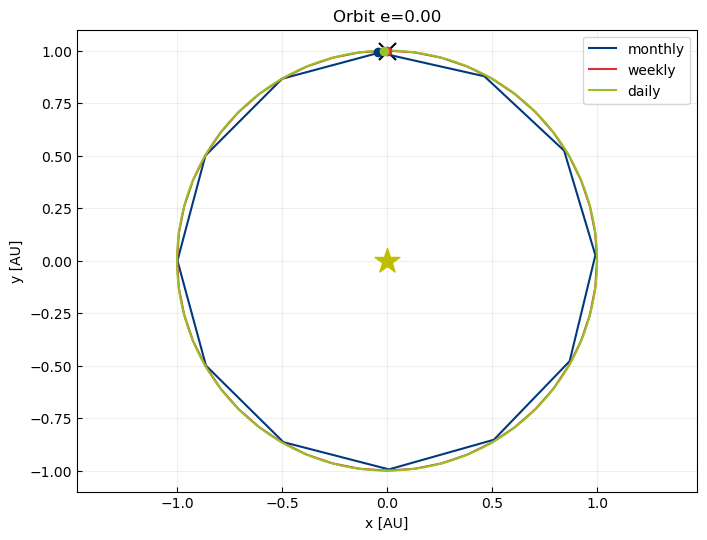

In [403]:
# For eccentricity 0
e = 0
calculate_orbit(e, tsteps, tsteps_label)

For monthly time steps --------------
	 Error in position: 3.454e+02 AU
	 Error in energy: 5.969e+04 AU^2/yr^2
For weekly time steps --------------
	 Error in position: 9.545e+01 AU
	 Error in energy: 4.580e+03 AU^2/yr^2
For daily time steps --------------
	 Error in position: 1.224e+01 AU
	 Error in energy: 8.270e+01 AU^2/yr^2


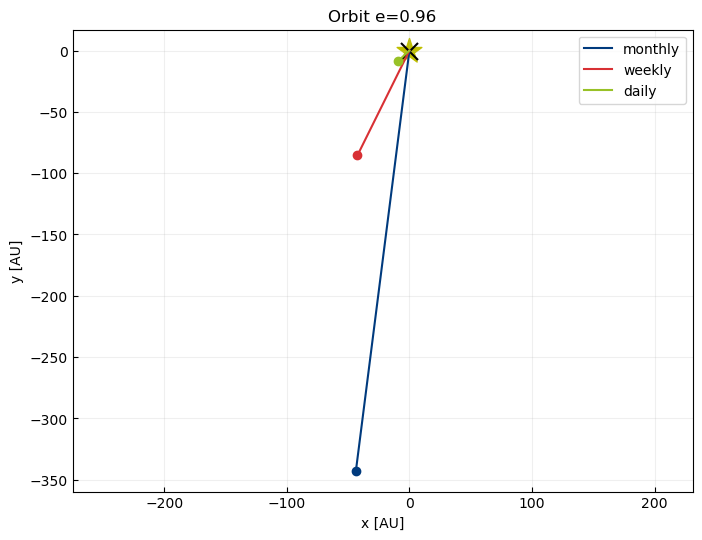

In [406]:
# For eccentricity 0.96
e = 0.96
calculate_orbit(e, tsteps, tsteps_label)

For a circular orbit with fixed timesteps, the error in position is quite good regardless of the timestep. Of course, the errors are better for smaller timesteps. The error in energy (per test mass) is impressively small for the daily time step.

For an eccentric orbit of e = 0.96, the position and energy are way off. All time steps are far too big while the velocity is large and the orbit becomes unbound. The fixed timestep fails for this eccentric orbit.

## Kepler Problem with Adaptive Timestep

In [381]:
# Computes a 4th order Runge-Kutta with an adaptive timestep to solve the Kepler problem
# INPUTS: array of initial conditions, initial time step size, maximum time to integrate through, and desired error
# RETURNS: Astropy table containing positions and velocities at each step

def rk4_orbit_adapt(s0, tstep0, tmax, err_goal):

    # Table to store final values in, don't know how many steps we will use yet
    orbit = Table(names=('t','r_x','r_y','v_x','v_y'), dtype=('float32','float32','float32','float32','float32'))

    # Initial conditions
    t = 0; s = s0.copy(); tstep = tstep0
    orbit.add_row([t, s[0], s[1], s[2], s[3]])

    while t < tmax:

        # Make sure that final step is exactly tmax - since error analysis relative to initial orbit position
        if (t + tstep > tmax):
            t = tmax - tstep

        # Evaluate with fixed timestep of tstep
        k1 = update(t,s)
        k2 = update(t+(tstep/2), s+k1*(tstep/2))
        k3 = update(t+(tstep/2), s+k2*(tstep/2))
        k4 = update(t+tstep, s+k3*tstep)
        s_fixed = s + tstep / 6 * (k1 + 2*k2 + 2*k3 + k4)
        
        # radius of orbit from one step
        r_fixed = np.sqrt(s_fixed[0]**2 + s_fixed[1]**2)

        # Evaluate with two equal steps of tstep/2
        t_small = tstep/2
        
        k1 = update(t,s)
        k2 = update(t+(t_small/2), s+k1*(t_small/2))
        k3 = update(t+(t_small/2), s+k2*(t_small/2))
        k4 = update(t+t_small, s+k3*t_small)
        s_first = s + t_small / 6 * (k1 + 2*k2 + 2*k3 + k4)
        
        k1 = update(t,s_first)
        k2 = update(t+(t_small/2), s_first+k1*(t_small/2))
        k3 = update(t+(t_small/2), s_first+k2*(t_small/2))
        k4 = update(t+t_small, s_first+k3*t_small)
        s_2steps = s_first + t_small / 6 * (k1 + 2*k2 + 2*k3 + k4)

        # radius of orbit from two steps
        r_2steps = np.sqrt(s_2steps[0]**2 + s_2steps[1]**2)

        # calculate relative error of two radii
        err_rel = np.abs(1 - r_fixed/r_2steps)

        # if error is smaller than goal, accept the step and update time, position, velocity
        if (err_rel <= err_goal):
            t += tstep
            s = s_2steps
            orbit.add_row([t, s_2steps[0], s_2steps[1], s_2steps[2], s_2steps[3]])

        # update new step size based on estimated error
        tstep = tstep * (err_goal/err_rel)**(1/5)
            
    return orbit

Orbit completed in 59 steps.
Error in position after 25 orbits: 1.409e-02 AU
Error in energy (per test mass) after 25 orbits: 1.505e-02 AU^2/yr^2


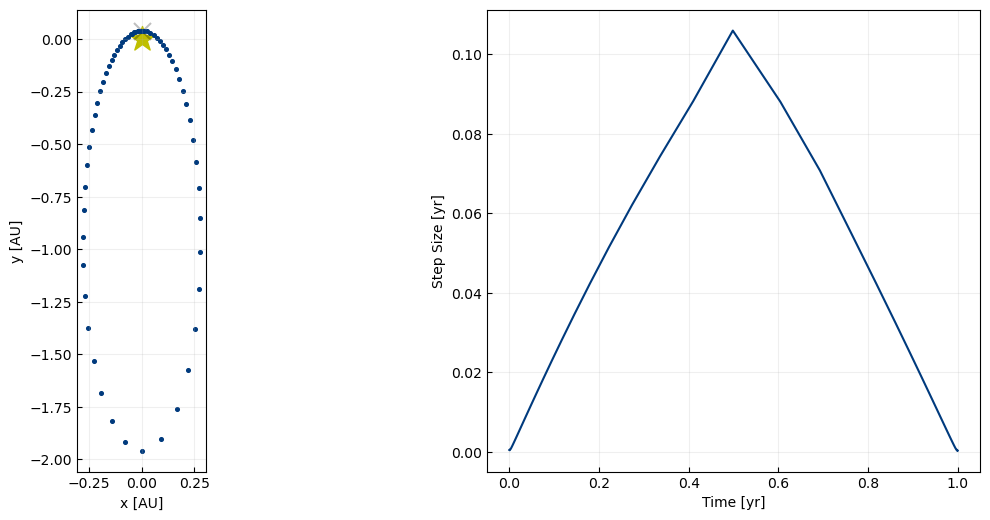

In [407]:
# Setup values
e = 0.96
tstep0 = 1./12
tmax = 1
err_goal = 10**-5

# New initial conditions
rx0 = 0
ry0 = a*(1-e)
vx0 = -np.sqrt(G * M / a) * np.sqrt((1+e)/(1-e))
vy0 = 0

r0 = np.sqrt(rx0**2 + ry0**2)
Etot0 = 0.5*(vx0**2 + vy0**2) - G*M/r0
s0 = np.array([rx0, ry0, vx0, vy0])


fig, axs = plt.subplots(1,2, figsize=(14,6))

# plot sun and starting position
axs[0].scatter([0], [0], marker='*', color="y", s=350)
axs[0].scatter([rx0],[ry0], marker='x', color='k', s=150,alpha=0.25)

# calculate orbit & step sizes
orbit = rk4_orbit_adapt(s0, tstep0, tmax, err_goal)
step_sizes = np.diff(orbit['t'])
print('Orbit completed in', len(step_sizes), 'steps.')

# plot orbit
axs[0].scatter(orbit['r_x'], orbit['r_y'], s=7)
axs[0].set_xlabel('x [AU]')
axs[0].set_ylabel('y [AU]')
axs[0].set_aspect('equal')
axs[0].grid(alpha=0.2)

# plot step sizes along the orbit
axs[1].plot(orbit['t'][:-1], step_sizes)
axs[1].set_xlabel('Time [yr]')
axs[1].set_ylabel('Step Size [yr]')
axs[1].grid(alpha=0.2)

err = get_error(orbit['r_x'][-1],orbit['r_y'][-1],orbit['v_x'][-1],orbit['v_y'][-1])
print('Error in position after 25 orbits: %0.3e AU'%(err[0]))
print('Error in energy (per test mass) after 25 orbits: %0.3e AU^2/yr^2'%(err[1]))

Error in position after 25 orbits: 1.021e+00 AU
Error in energy (per test mass) after 25 orbits: 1.020e-01 AU^2/yr^2


Text(0, 0.5, 'Energy per unit mass [AU^2/yr^2]')

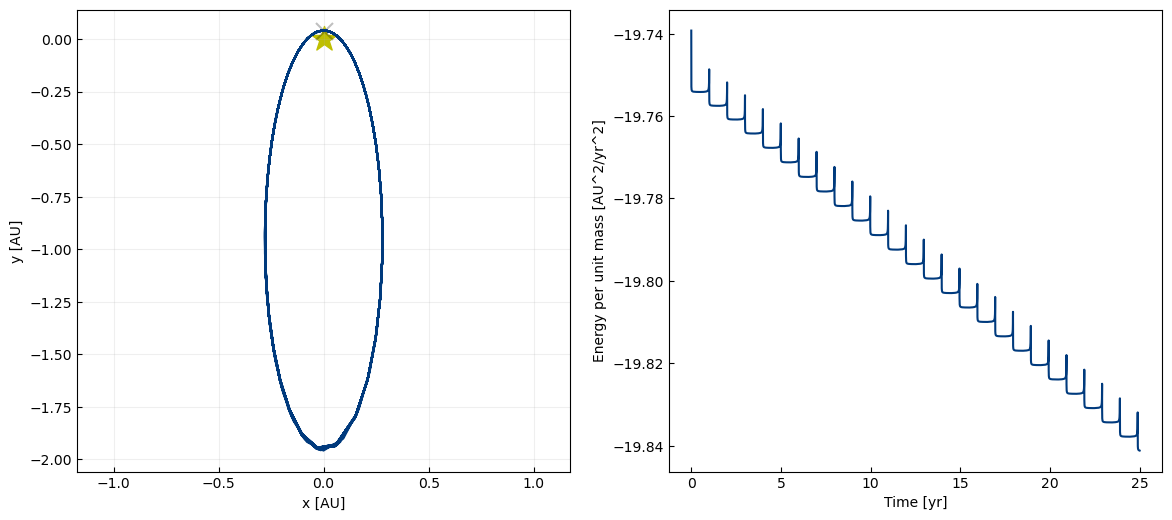

In [415]:
# Calculate & plot orbit after 25 years
orbit25 = rk4_orbit_adapt(s0, tstep0, 25, err_goal)

fig, axs = plt.subplots(1,2, figsize=(14,6))

axs[0].scatter([0], [0], marker='*', color="y", s=350)
axs[0].scatter([rx0],[ry0], marker='x', color='k', s=150,alpha=0.25)

axs[0].plot(orbit25['r_x'], orbit25['r_y'])
axs[0].set_xlabel('x [AU]')
axs[0].set_ylabel('y [AU]')
axs[0].axis('equal')
axs[0].grid(alpha=0.2)

err = get_error(orbit25['r_x'][-1],orbit25['r_y'][-1],orbit25['v_x'][-1],orbit25['v_y'][-1])
print('Error in position after 25 orbits: %0.3e AU'%(err[0]))
print('Error in energy (per test mass) after 25 orbits: %0.3e AU^2/yr^2'%(err[1]))

# Calculate energy at each time step
energy = 0.5*(orbit25['v_x']**2+orbit25['v_y']**2) - G*M/np.sqrt(orbit25['r_x']**2+orbit25['r_y']**2)
axs[1].plot(orbit25['t'], energy)
axs[1].set_xlabel('Time [yr]')
axs[1].set_ylabel('Energy per unit mass [AU^2/yr^2]')

The 1yr orbit completed in 59 steps and preserved energy and position quite well (~1.5%). However, each successive orbit has slightly worse energy than the previous orbit. After 25 years, the e